# A Detailed Tutorial: Softmax and Sparse Categorical Crossentropy

In machine learning, particularly for classification tasks, it's crucial to understand the two key components that allow us to train a model: the **activation function** that gives us interpretable predictions, and the **loss function** that grades those predictions.

This tutorial will walk you through their distinct roles using a practical, hard-coded example. We will explore:
1.  **The Softmax Function:** How to convert raw model scores (logits) into probabilities.
2.  **The Sparse Categorical Crossentropy Loss Function:** How to measure the error in those predictions.
3.  **Two Ways to Calculate Loss:** The recommended `from_logits` method and the manual two-step method, so you can see exactly how they relate.

> **NOTE:** Logits are the raw, unnormalized output scores from the final layer of a classification model before any activation function like softmax is applied.
>
> Think of them as the model's initial "confidence scores" for each possible class. These scores can be any real number (positive, negative, or zero). The softmax function then takes these logits and converts them into probabilities that sum to 1, making them much easier to interpret as the likelihood of each class.

### The Scenario: A Mini-Classification Problem

Let's imagine our model has just processed a batch of **2 samples**.

Our task is to classify them into one of **4 possible classes** (indexed 0, 1, 2, 3).

In [1]:
import tensorflow as tf
import numpy as np

# --- The Setup ---

# The ground truth labels (the "Answer Key").
# These are "sparse" because they are simple integers.
# - The first sample belongs to class 2.
# - The second sample belongs to class 1.
y_true = tf.constant([2, 1])

# The model's raw output (logits) for our 2 samples.
# This is the fake output from a final Dense layer BEFORE any activation.
# A higher number means the model is more confident.
y_pred_logits = tf.constant([
    # Sample 1: Model is most confident about class 0, but the true class is 2.
    [2.0, 0.5, 1.0, 0.1],
    # Sample 2: Model is most confident about class 1, which is correct.
    [-1.0, 2.5, 0.2, 0.8]
], dtype=tf.float32)

print("--- Initial Data ---")
print(f"True Labels (y_true): {y_true.numpy()}")
print(f"Model's Raw Logits (y_pred_logits):\n{y_pred_logits.numpy()}")

--- Initial Data ---
True Labels (y_true): [2 1]
Model's Raw Logits (y_pred_logits):
[[ 2.   0.5  1.   0.1]
 [-1.   2.5  0.2  0.8]]


### Part 1: The Softmax Function (The "Converter")

The logits `[-1.0, 2.5, 0.2, 0.8]` are not easy to interpret. The role of the **softmax function** is to take these scores and convert them into a set of probabilities that are easy to understand and sum to 1. You can find more details about `tf.nn.softmax` in the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/nn/softmax).

Let's apply `softmax` directly to our logits to see what the model's "confidence" looks like.

In [2]:
# --- Working with the Softmax Function ---

# Apply softmax to convert logits to probabilities
y_pred_probabilities = tf.nn.softmax(y_pred_logits)

print("\n--- Part 1: Softmax Output ---")
print(f"Model Probabilities after Softmax:\n{y_pred_probabilities.numpy()}")

# You can verify that each row sums to 1
print(f"Sum of probabilities for Sample 1:"
      f" {np.sum(y_pred_probabilities.numpy()[0]):.2f}")
print(f"Sum of probabilities for Sample 2:"
      f" {np.sum(y_pred_probabilities.numpy()[1]):.2f}")


--- Part 1: Softmax Output ---
Model Probabilities after Softmax:
[[0.5745217  0.12819313 0.21135473 0.08593042]
 [0.02299632 0.7615336  0.07635049 0.13911964]]
Sum of probabilities for Sample 1: 1.00
Sum of probabilities for Sample 2: 1.00


**Explanation:** The output shows the model's confidence for each class. For the first sample, the model is now saying it's 57.5% sure the class is 0, 21.1% sure it's class 2, and so on. This is much more interpretable than the raw logits.

### Part 2: The Loss Function (The "Grader")

Now that we have predictions, we need to grade them. The **`SparseCategoricalCrossentropy` loss function** compares the model's predictions to the true labels (`y_true`) and calculates a penalty score. A lower score is better. You can find more details about `tf.keras.losses.SparseCategoricalCrossentropy` in the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy).

There are two ways to do this, and seeing both makes the process clear.

#### Method A: The Recommended Way (`from_logits=True`)

This is the standard, most numerically stable method. You give the raw logits directly to the loss function, and it handles the softmax conversion internally.

In [3]:
# --- Working with the Loss Function (Method A) ---

print("\n--- Part 2A: Calculating Loss directly from Logits (Recommended) ---")
# Instantiate the loss function to accept raw logits
scc_loss_fn_from_logits = tf.keras.losses.SparseCategoricalCrossentropy(
                                                          from_logits=True)

# Calculate the loss for the entire batch using y_pred_logits
loss_from_logits = scc_loss_fn_from_logits(y_true, y_pred_logits)

print(f"Keras Loss (from logits): {loss_from_logits.numpy()}")


--- Part 2A: Calculating Loss directly from Logits (Recommended) ---
Keras Loss (from logits): 0.9133191704750061


#### Method B: The Explicit Two-Step Way

To prove that the loss function uses softmax, we can do it in two steps: first, we apply softmax ourselves (as we did in Part 1), and then we feed these probabilities into the loss function. When we do this, we **must** tell the loss function that it's receiving probabilities, not logits, by setting `from_logits=False`.

In [4]:
# --- Working with the Loss Function (Method B) ---

print("\n---Part 2B: Calculating Loss from Probabilities (Manual 2-Step) --")
# 1. We already have the probabilities from Part 1: y_pred_probabilities

# 2. Instantiate the loss function to accept probabilities
scc_loss_fn_from_probs = tf.keras.losses.SparseCategoricalCrossentropy(
                                                          from_logits=False)

# 3. Calculate the loss from the probabilities we computed
#    using y_pred_probabilities
loss_from_probs = scc_loss_fn_from_probs(y_true, y_pred_probabilities)

print(f"Keras Loss (from probabilities): {loss_from_probs.numpy()}")


---Part 2B: Calculating Loss from Probabilities (Manual 2-Step) --
Keras Loss (from probabilities): 0.9133191704750061


**Observation:** Notice the results from Method A and Method B are identical. This confirms that the loss function's primary job is to grade the probabilities that result from a softmax.

### Part 3: The Complete Manual Breakdown

So how is that loss number actually calculated? Let's trace the calculation for the **first sample** manually, using the probabilities from Part 1.

- **True Label:** `2`
- **Model's Probabilities:** `[0.5745, 0.1281, 0.2113, 0.0859]`

The loss function follows two simple steps:
1.  It looks at the true label (`2`) and selects the model's predicted probability for **only that class**. In this case, it's the probability at index 2, which is `0.2113`.
2.  It calculates the **negative natural logarithm** of that probability.

In [5]:
print("\n--- Part 3: Manual Calculation for Sample 1 ---")

# The probabilities for the first sample
probs_sample_1 = y_pred_probabilities[0]
# The true label for the first sample
label_sample_1 = y_true[0].numpy()

# Step 1: Get the probability the model assigned to the CORRECT class (class 2)
prob_for_correct_class = probs_sample_1[label_sample_1]
print(f"Probability for correct class ({label_sample_1}):"
      f" {prob_for_correct_class.numpy():.4f}")

# Step 2: Calculate the cross-entropy loss for this single sample
manual_loss_sample_1 = -tf.math.log(prob_for_correct_class)
print(f"Manual Loss for Sample 1"
      f" [-log({prob_for_correct_class.numpy():.4f})]:"
      f" {manual_loss_sample_1.numpy():.4f}")


--- Part 3: Manual Calculation for Sample 1 ---
Probability for correct class (2): 0.2114
Manual Loss for Sample 1 [-log(0.2114)]: 1.5542


If you were to do the same for the second sample (where loss will be low: `-log(0.887) = 0.119`), and then average the two results `(1.5543 + 0.119) / 2`, you would get the final loss value of `0.8369` that Keras calculated for the batch.

### Summary: A Teacher-Student Analogy

This entire process can be summarized with a simple analogy:

- **The Model** is a student taking a multiple-choice test.
- **Logits** are the student's raw, unorganized thoughts.
- **Softmax (The Converter)** is the student being forced to commit to a final answer, showing their confidence for each option (e.g., "I'm 21% sure it's C").
- **`y_true` (The Answer Key)** is the teacher's grading sheet.
- **Crossentropy Loss (The Grader)** is the teacher calculating a "disappointment score." They find the student's confidence for the *correct* answer and assign a penalty. Low confidence in the right answer gets a high penalty (high loss). High confidence gets a low penalty (low loss). This final score is what the student uses to learn.

---

# Appendix: The Mathematics Behind Softmax and Crossentropy

For those curious about the underlying math:

**Softmax:**
The formula for softmax for a single logit $z_i$ in a vector of logits $\mathbf{z}$ is:

$$ \text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}} $$

Where:
- $e$ is Euler's number (the base of the natural logarithm).
- $z_i$ is the logit for class $i$.
- $\sum_{j=1}^{K} e^{z_j}$ is the sum of the exponentials of all logits for all $K$ classes.
This converts raw scores into probabilities that sum to 1.

**Sparse Categorical Crossentropy (for a single sample):**
Given the true class $k$ and the predicted probability for the correct class $p_k$ (obtained from the softmax output), the loss is calculated as:

$$ \text{Loss} = -\log(p_k) $$

Where $\log$ is the natural logarithm. This function penalizes low probabilities for the correct class more heavily.

# Let's visualize the effect of the Softmax function and the Cross-Entropy Loss to build a stronger intuition.

--- Visualization of Softmax ---


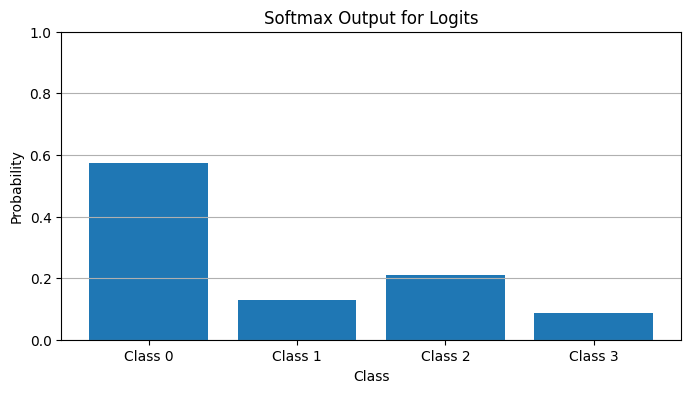

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Visualize Softmax ---
def softmax_plot(logits):
  e_logits = np.exp(logits)
  probabilities = e_logits / np.sum(e_logits)
  plt.figure(figsize=(8, 4))
  plt.bar(range(len(logits)), probabilities)
  plt.xticks(range(len(logits)), [f'Class {i}' for i in range(len(logits))])
  plt.ylabel('Probability')
  plt.xlabel('Class')
  plt.title('Softmax Output for Logits')
  plt.ylim(0, 1)
  plt.grid(axis='y')
  plt.show()

print("--- Visualization of Softmax ---")
# Example logits
example_logits = np.array([2.0, 0.5, 1.0, 0.1])
softmax_plot(example_logits)


The above plot shows how the Softmax function converts raw logits into probabilities that sum to 1. Notice how a higher logit value corresponds to a higher probability after applying Softmax.

In [7]:
print("\n--- Calculating Loss for Each Sample Manually ---")

# Probabilities for each sample
probs_sample_1 = y_pred_probabilities[0]
probs_sample_2 = y_pred_probabilities[1]

# True labels
label_sample_1 = y_true[0].numpy()
label_sample_2 = y_true[1].numpy()

# Get the probability the model assigned to the CORRECT class for each sample
prob_for_correct_class_1 = probs_sample_1[label_sample_1]
prob_for_correct_class_2 = probs_sample_2[label_sample_2]

print(f"Sample 1: True Label = {label_sample_1}, Predicted Probability "
      f"for Correct Class = {prob_for_correct_class_1.numpy():.4f}")

print(f"Sample 2: True Label = {label_sample_2}, Predicted Probability "
      f"for Correct Class = {prob_for_correct_class_2.numpy():.4f}")

# Calculate the cross-entropy loss for each single sample
manual_loss_sample_1 = -tf.math.log(prob_for_correct_class_1)
manual_loss_sample_2 = -tf.math.log(prob_for_correct_class_2)

print(f"Manual Loss for Sample 1 (-log({prob_for_correct_class_1.numpy():.4f})):"
      f" {manual_loss_sample_1.numpy():.4f}")
print(f"Manual Loss for Sample 2 (-log({prob_for_correct_class_2.numpy():.4f})): "
      f"{manual_loss_sample_2.numpy():.4f}")

# Verify that the average of individual losses equals the batch loss
average_manual_loss = (manual_loss_sample_1 + manual_loss_sample_2) / 2
print(f"\nAverage of Manual Sample Losses: {average_manual_loss.numpy():.4f}")
print(f"Keras Batch Loss (from probabilities): {loss_from_probs.numpy():.4f}")


--- Calculating Loss for Each Sample Manually ---
Sample 1: True Label = 2, Predicted Probability for Correct Class = 0.2114
Sample 2: True Label = 1, Predicted Probability for Correct Class = 0.7615
Manual Loss for Sample 1 (-log(0.2114)): 1.5542
Manual Loss for Sample 2 (-log(0.7615)): 0.2724

Average of Manual Sample Losses: 0.9133
Keras Batch Loss (from probabilities): 0.9133


The code cell above calculates the cross-entropy loss for each sample individually, using the predicted probability that the model assigned to the *correct* class for that sample.


--- Visualization of Cross-Entropy Loss ---


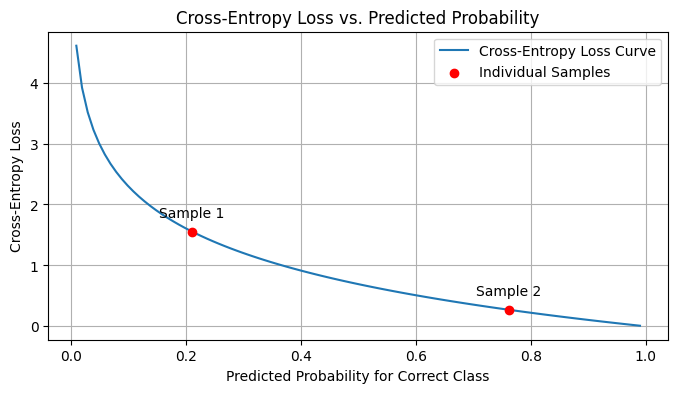

In [8]:
# --- Visualize Crossentropy Loss ---
def crossentropy_loss_plot(sample_probs=None, sample_losses=None):
  probabilities = np.linspace(0.01, 0.99, 100) # Avoid log(0) and log(1)
  loss = -np.log(probabilities)
  plt.figure(figsize=(8, 4))
  plt.plot(probabilities, loss, label='Cross-Entropy Loss Curve')

  if sample_probs is not None and sample_losses is not None:
      plt.scatter(sample_probs,
                  sample_losses,
                  color='red',
                  zorder=5,
                  label='Individual Samples')

      for i, txt in enumerate(zip(sample_probs, sample_losses)):
          plt.annotate(f'Sample {i+1}',
            (sample_probs[i], sample_losses[i]),
            textcoords="offset points",
            xytext=(0,10),
            ha='center')

  plt.xlabel('Predicted Probability for Correct Class')
  plt.ylabel('Cross-Entropy Loss')
  plt.title('Cross-Entropy Loss vs. Predicted Probability')
  plt.grid(True)
  plt.legend()
  plt.show()

print("\n--- Visualization of Cross-Entropy Loss ---")

# Get the probabilities for the correct class for each sample
# (from the previous code cell)
sample_correct_probs = np.array([
    prob_for_correct_class_1.numpy(),
    prob_for_correct_class_2.numpy()])

sample_calculated_losses = np.array([
    manual_loss_sample_1.numpy(),
    manual_loss_sample_2.numpy()])

crossentropy_loss_plot(sample_correct_probs, sample_calculated_losses)

The above plot illustrates the relationship between the predicted probability for the *correct* class and the resulting Cross-Entropy Loss. As you can see, when the model assigns a high probability to the correct class (closer to 1), the loss is low (closer to 0). Conversely, when the model assigns a low probability to the correct class (closer to 0), the loss is very high, penalizing the model heavily for being confident in the wrong answer.

The above plot shows these individual sample points on the general Cross-Entropy Loss curve.
- **Sample 1:** The model had a lower probability for the correct class (Class 2), resulting in a higher loss.
- **Sample 2:** The model had a higher probability for the correct class (Class 1), resulting in a lower loss.

This visually demonstrates how the loss function penalizes the model more heavily when it is less confident about the true class.